<center>
# Прогнозирование геологических характеристик нефтеносных пластов

<center>
## Цель

В данной задаче Вам предлагается, используя различные методы картопостроения (начиная от простых интерполяционных алгоритмов и заканчивая сложными моделями машинного обучения), предсказать значения параметра **песчанистости** в точках между скважинами.

**Целевой метрикой является - корень среднеквадратичной ошибки (RMSE)**.

<center>
## Описание кейса
В реальной жизни для изучения свойств целевого пласта на месторождении бурятся скважины, после чего в них опускаются специальные устройства - каротажные зонды. С их помощью проводится запись различных геофизических полей (например, радиоактивность или плотность), создаваемых горными породами. Подобные исследования называются геофизическими исследования скважин - ГИС. На основе полученных данных специалисты петрофизики проводят интерпретацию и сообщают информацию о том, на какой глубине находится пласт-коллектор, который может накапливать и отдавать флюиды. Типичный пример различных каротажных кривых и их совместной интерпретации представлен на рисунке.
<img src="img\log_interpretation.png">
На основе полученной интерпретации можно посчитать такое свойство как песчанистость в зоне бурения скважины. Песчанистость - это отношение толщин пластов-коллекторов к общей толщине геологического образования, данная характеристика позволяет геологам делать предположения об экономической эффективности работы с этим месторождением.
К сожалению, бурение скважин является очень дорогостоящей операцией, поэтому мы используем различные алгоритмы картопостроения с целью прогноза свойств в межскважинном пространстве.

В качестве данных в представленной задаче используется информация из синтетической модели месторождения, которая была построена на основе геологического обнажения Шестаково, Кемеровская область. По его описанию были определены различные геологические паараметры (размеры и геометрия тел, их связанность и значение песчанистости), которые в дальнейшем использовались при построение 3D модели. Подобный подход позволил достаточно точно отобразить реальную геологию (которая обычно не доступна для визуального анализа) и использовать полученный результат в качестве полигона для опробования и оценки различных подходов.
<img src="img\Razrez.png" width = 800>

Полученная в результате работ модель представляет из себя 3D грид, в котором каждой координате соответствует полигон 200х200 метров с некоторым количеством ячеек по глубине. Каждая ячейка характеризуется дисретным значением - песчанник (коллектор) или глина (неколлектор). Таким образом **для каждой координаты мы имеем значение песчанистоти**. Эти данные будут использоваться как **ground truth** для проверки качества решения.
<img src="img\3D_model.png" width = 800>

В предоставленном наборе данных имеется информация о 10% скважинных данных (в реальной жизни их может быть менее 1% от площади месторождения!), используя которые, Вам предлагается построить алгоритм, который бы предсказывал значения песчанистости в точках с отсутствующими значениями.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
%matplotlib inline

In [2]:
#load data
data = pd.read_csv(r'data/Training_wells.csv')

In [3]:
data.describe()

X           Y         NTG
count  138.000000  138.000000  138.000000
mean   223.195652  916.630435    0.325720
std     13.590926    8.765456    0.072432
min    201.000000  901.000000    0.177000
25%    211.000000  909.000000    0.270175
50%    222.500000  917.000000    0.325900
75%    236.500000  924.000000    0.377475
max    246.000000  930.000000    0.562500

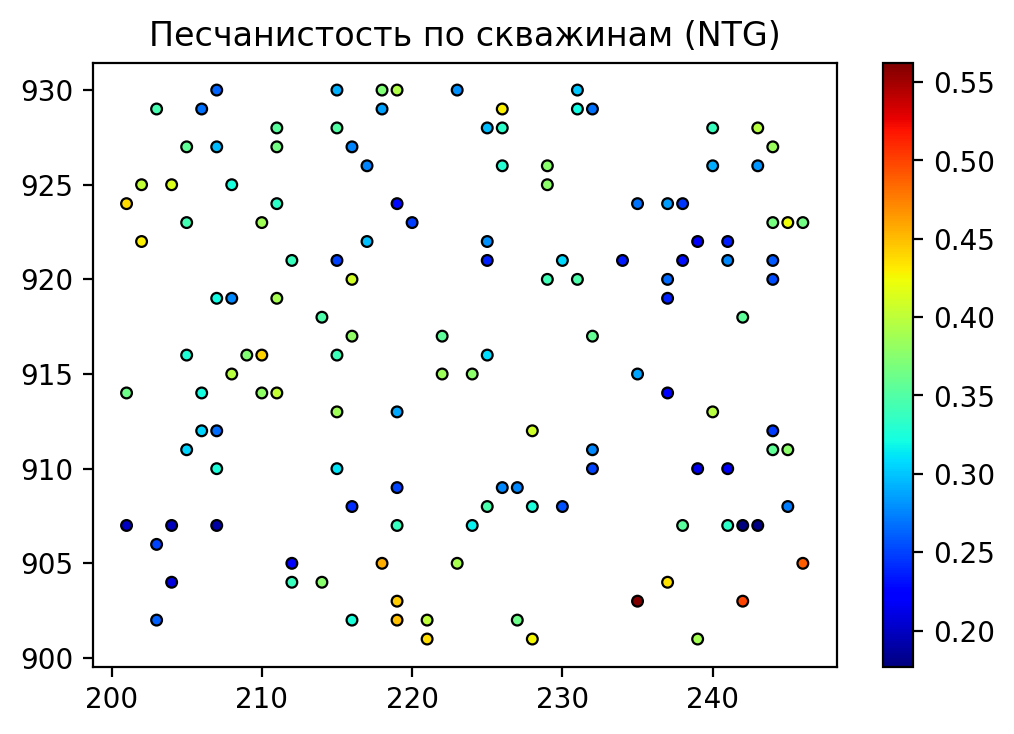

In [4]:
# Отрисуем имеющиеся данные
plt.figure(dpi = 200)
plt.title('Песчанистость по скважинам (NTG)')
plt.scatter(data.X, data.Y, cmap = 'jet', c = data.NTG, marker='o', lw = 0.8, edgecolors='black', s = 15)
plt.colorbar()
plt.show()

<center>
## Построение признакового пространства

В представленном решении в качестве признаков используются три ближайших к целевой точке значения и расстояния до них. Таким образом для каждой точки рассчитываются 6 признаков, которые в дальнейшем используются при прогнозировании. На рисунке ниже продемонстрирован пример такого построения признакового пространства.
<img src="img\neighbors.png">

In [5]:
# Создадим признаковое пространство по имеющимся данным
# Для кажой имеющейся скважины мы можем определить расстояние до ближайших точек и песчанистость в них
# Эта информация будет использоваться в качестве признаков, на основе которых будет строиться предсказание
feature_set = np.empty([0, 7])
for well in data.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    train = np.hstack([well_distance[1:],
                       data.loc[index[1:], 'NTG'].values,
                       data.loc[data.Well==well, 'NTG'].values])
    feature_set = np.vstack([feature_set, train])

In [6]:
# Разобьем выборку на тренировочную и отложенную части
Feature_data = feature_set[:, :6]
Target_data = feature_set[:, 6]
X_train, X_test, y_train, y_test = train_test_split(Feature_data,
                                                    Target_data, random_state = 17, test_size = 0.2)

In [7]:
# Создадим и обучим модель с последующим прогнозом отложенной части
clf = Ridge(alpha=0.2, random_state = 17)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [8]:
# Посчитаем метрики результата
print('RMSE ошибка равна',np.sqrt(mean_squared_error(y_test, prediction)).round(4))

RMSE ошибка равна 0.0566


In [9]:
# Обучим модель на всем пуле имеющихся данных
clf.fit(Feature_data, Target_data)

Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [10]:
# Проведем предсказание для пустых точек
empty = pd.read_csv('data/Empty_part.csv')

feature_set_test = np.empty([0, 6])
for well in empty.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    train = np.hstack([well_distance[1:],
                      data.loc[index[1:], 'NTG'].values])
    feature_set_test = np.vstack([feature_set_test, train])

In [11]:
# Предскажем значения для пустых точек и объединим с имеющимися для дальнейшей отрисовки
empty['NTG'] = clf.predict(feature_set_test)
resulting_pd = empty.append(data)

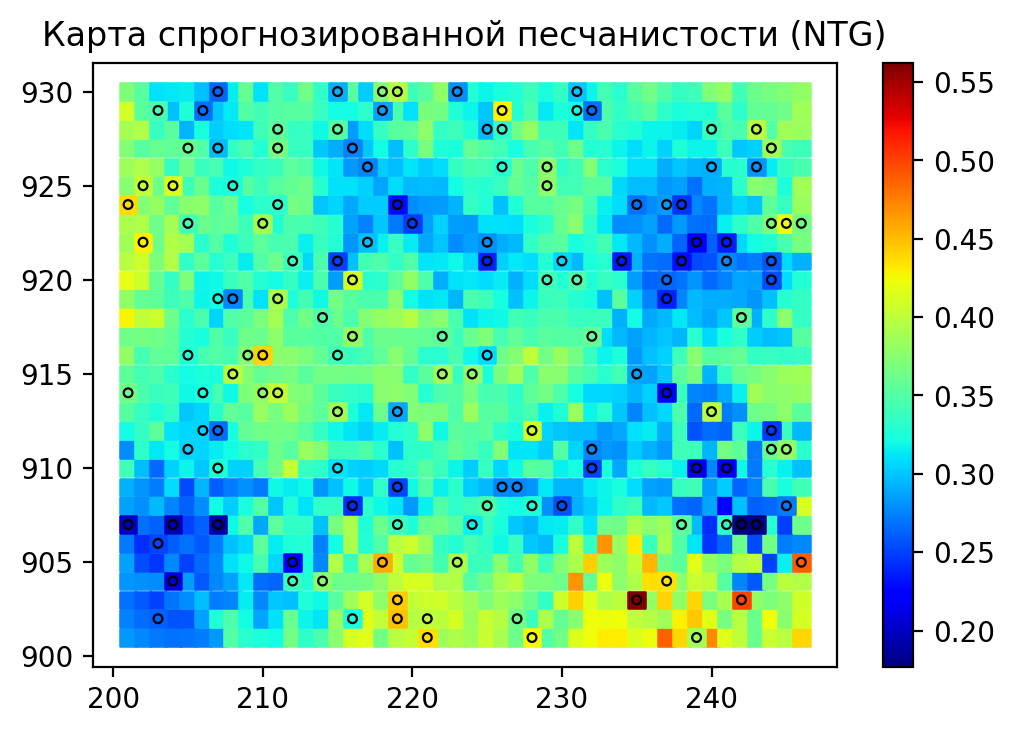

In [12]:
# Отрисуем полученную после прогноза карту
plt.figure(dpi = 200)
plt.title('Карта спрогнозированной песчанистости (NTG)')
plt.scatter(resulting_pd.X, resulting_pd.Y, cmap = 'jet', c = resulting_pd.NTG, marker='s', lw = 0.92)
plt.colorbar()
plt.scatter(data.X, data.Y, cmap = 'jet', c = data.NTG, marker='o', lw = 0.8, edgecolors='black', s = 10)
plt.show()

In [13]:
#load data
data = pd.read_csv(r'data/Training_wells.csv')
def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)

# def get_best_up(data):
#     best_points = []
#     for index, point in data.iterrows():
#         if float(point['NTG']) > 0.45:
#             best_points.append(point)
        
        
#     for point in best_points:
#         print(point)
#         x = str(point["X"] + 2)
#         y =  str(point["Y"] + 2)
#         data = data.append({'Well': x + "-" + y,
#                         'X': int(x),
#                         'Y': int(y),
#                         'NTG': point["NTG"]},ignore_index=True)
        
#         x = str(point["X"] - 2)
#         y =  str(point["Y"] - 2)
#         newPoint = [x + "-" + y , int(x), int(y) , point["NTG"]]
#         df2 = pd.DataFrame(newPoint)
#         data = data.append({'Well': x + "-" + y,
#                         'X': int(x),
#                         'Y': int(y),
#                         'NTG': point["NTG"]},ignore_index=True)
# #         x = str(point["X"] + 10)
# #         y =  str(point["Y"] - 10)
# #         newPoint = [x + "-" + y , int(x), int(y) , point["NTG"]]
# #         df2 = pd.DataFrame(newPoint)
# #         data = data.append({'Well': x + "-" + y,
# #                         'X': int(x),
# #                         'Y': int(y),
# #                         'NTG': point["NTG"]},ignore_index=True)
        
# #         x = str(point["X"] - 10)
# #         y =  str(point["Y"] + 10)
# #         newPoint = [x + "-" + y , int(x), int(y) , point["NTG"]]
# #         df2 = pd.DataFrame(newPoint)
# #         data = data.append({'Well': x + "-" + y,
# #                         'X': int(x),
# #                         'Y': int(y),
# #                         'NTG': point["NTG"]},ignore_index=True)
    
#     return data

# data = get_best_up(data)    
# data.describe()

In [14]:
# Создадим признаковое пространство по имеющимся данным
# Для кажой имеющейся скважины мы можем определить расстояние до ближайших точек и песчанистость в них
# Эта информация будет использоваться в качестве признаков, на основе которых будет строиться предсказание
feature_set = np.empty([0, 7])
for well in data.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    train = np.hstack([well_distance[1:],
                       data.loc[index[1:], 'NTG'].values,
                       data.loc[data.Well==well, 'NTG'].values])
    feature_set = np.vstack([feature_set, train])
    
# Разобьем выборку на тренировочную и отложенную части
Feature_data = feature_set[:, :6]
Target_data = feature_set[:, 6]
X_train, X_test, y_train, y_test = train_test_split(Feature_data,
                                                    Target_data, random_state = 17, test_size = 0.2)
# Создадим и обучим модель с последующим прогнозом отложенной части
clf = Ridge(alpha=0.2, random_state = 17)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
# Посчитаем метрики результата
print('RMSE ошибка равна',np.sqrt(mean_squared_error(y_test, prediction)).round(4))

RMSE ошибка равна 0.0566


In [15]:

feature_set_user = np.empty([0, 6])
for well in data.Well.unique():
    
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    NTGs = data.loc[index[1:], 'NTG'].values
    mas_NTGs = sum(NTGs)
    distance_sum = sum(well_distance)
    distance_1 = well_distance[1]
    NTG_1 = NTGs[0]*NTGs[0]
    distance_2 = well_distance[2]
    NTG_2 =NTGs[1]*  NTGs[1]
    distance_3 = well_distance[3]
    NTG_3 = NTGs[2]* NTGs[2]
    train = np.hstack([NTG_1/distance_1, NTG_2/distance_2, NTG_3/distance_3,mas_NTGs,distance_sum,
                       data.loc[data.Well==well, 'NTG'].values])
    feature_set_user = np.vstack([feature_set_user, train])
print(getPreprocessing(feature_set_user))

[[ -1.06965129e+00  -1.27161467e+00  -1.38614607e+00  -1.95602211e+00
    9.88885596e-01  -1.73370584e+00]
 [ -1.17195315e+00  -1.07866590e+00  -8.22412773e-01  -9.69721674e-02
    3.43505956e+00   5.08258512e-01]
 [  9.06674433e-01   1.05290000e+00   9.58875449e-01   1.70894420e+00
   -3.17204394e-01   1.55718745e+00]
 [  2.51842204e-01   1.00911158e-01   5.52607723e-02   1.32575738e+00
    4.59638697e-01   1.42970863e+00]
 [  1.39820566e+00   1.16245842e+00   1.34576128e+00   1.93398051e+00
   -5.12345460e-01   1.05835731e+00]
 [ -1.27097345e+00  -1.17601128e+00  -1.52934398e+00  -1.95602211e+00
    1.89828615e+00  -8.71838210e-01]
 [ -1.08754510e+00  -1.10360959e+00  -8.90322202e-01  -2.27544865e+00
   -7.70934843e-01  -1.02564417e+00]
 [ -6.86380141e-01  -9.02926057e-01   1.61780329e-01   3.49349843e-01
    1.22051207e+00   2.69928556e-01]
 [ -1.01095586e+00  -7.56795100e-01  -1.24294381e+00  -1.62096805e+00
    5.90824813e-03  -1.61454086e+00]
 [ -6.91259020e-01  -1.25737019e+00  

In [16]:
# Обучим модель на всем пуле имеющихся данных
# Разобьем выборку на тренировочную и отложенную части
def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)

Feature_data = getPreprocessing(feature_set_user[:, :5])
Target_data = feature_set_user[:, 5]
X_train, X_test, y_train, y_test = train_test_split(Feature_data,
                                                    Target_data, random_state = 17, test_size = 0.18)

# Создадим и обучим модель с последующим прогнозом отложенной части
clf_user = Ridge(alpha=0.2, random_state = 17)
clf_user.fit(X_train, y_train)
prediction = clf_user.predict(X_test)

# Посчитаем метрики результата
print('RMSE ошибка равна',np.sqrt(mean_squared_error(y_test, prediction)).round(4))


clf_user.fit(Feature_data, Target_data)

RMSE ошибка равна 0.0545


Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [17]:
# Пользовательское решение
empty = pd.read_csv('data/Empty_part.csv')

feature_set_test = np.empty([0, 5])
for well in empty.Well.unique():
    target_point = list(map(int, well.split('-')))
    well_distance,index = cKDTree(data[['X', 'Y']]).query(target_point, k = 4)
    NTGs = data.loc[index[1:], 'NTG'].values
    mas_NTGs = sum(NTGs)
    distance_sum = sum(well_distance)
    distance_1 = well_distance[1]
    NTG_1 = NTGs[0]*NTGs[0]
    distance_2 = well_distance[2]
    NTG_2 =NTGs[1]*  NTGs[1]
    distance_3 = well_distance[3]
    train = np.hstack([NTG_1/distance_1, NTG_2/distance_2, NTG_3/distance_3,mas_NTGs,distance_sum])
    feature_set_test = np.vstack([feature_set_test, train])
print(feature_set_test)

[[  1.03154246e-02   1.17643363e-02   1.11284267e-02   6.61500000e-01
    1.78638735e+01]
 [  1.21381272e-02   1.41661369e-02   1.33541120e-02   6.61500000e-01
    1.50776872e+01]
 [  1.38395943e-02   1.75709303e-02   1.66926400e-02   6.61500000e-01
    1.30038969e+01]
 ..., 
 [  5.28278700e-02   2.19934634e-02   1.33541120e-02   1.04640000e+00
    1.38416193e+01]
 [  5.01169179e-02   1.86908498e-02   1.11284267e-02   1.04640000e+00
    1.62333455e+01]
 [  4.07905030e-02   1.58597120e-02   1.05573525e-02   1.00420000e+00
    1.85356579e+01]]


In [18]:
# Предскажем значения для пустых точек и объединим с имеющимися для дальнейшей отрисовки
empty['NTG'] = clf_user.predict(getPreprocessing(feature_set_test))
resulting_pd = empty.append(data)

In [19]:
# Отрисуем полученную после прогноза карту
plt.figure(dpi = 200)
plt.title('Карта спрогнозированной песчанистости (NTG)')
plt.scatter(resulting_pd.X, resulting_pd.Y, cmap = 'jet', c = resulting_pd.NTG, marker='s', lw = 0.92)
plt.colorbar()
plt.scatter(data.X, data.Y, cmap = 'jet', c = data.NTG, marker='o', lw = 0.8, edgecolors='black', s = 10)
plt.show()

In [20]:
# Выгрузим данные для последующей оценки, предварительно введя название своей команды
team_name = 'BurdinskiyVA'
empty.to_csv('%s_prediction.csv'%team_name, index = None)